In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
len(train[train['target']==0])

573518

Metadata:To facilitate the data management, we'll store meta-information about the variables in a DataFrame.
role: input, ID, target level: nominal, interval, ordinal, binary keep: True or False dtype: int, float, str

In [6]:
data = []

for f in train.columns:
    # Defining the role
    
    if f=='id':
        role = 'id'
    elif f=='target':
        role = 'target'
    else:
        role = 'input'
        
    # Defining the level
    
    if 'bin' in f or f=='target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'     #mainly 0 and 1
    elif train[f].dtype==float:
        level = 'interval'
    elif train[f].dtype==int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep=True
    if f=='id':
        keep=False
        
    # Defining the data type 
    
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    
    f_dict = {
        'varname':f,
        'role':role,
        'level':level,
        'keep':keep,
        'dtype':dtype
    }
    
    data.append(f_dict)
    
    meta = pd.DataFrame(data,columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)

In [7]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [8]:
#Below the number of variables per role and level are displayed.

pd.DataFrame({'count': meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


In [9]:
#Interval variables
v = meta[(meta.level == 'interval') & (meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [10]:
#Interval variables test
v = meta[(meta.level == 'interval') & (meta.keep)].index
test[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,0.611057,0.439868,0.551740,0.379957,0.813637,0.276431,3.068325,0.449632,0.450453,0.450054
std,0.287699,0.404678,0.794023,0.058385,0.224779,0.356835,0.729005,0.287213,0.287373,0.287254
min,0.000000,0.000000,-1.000000,0.141421,0.275778,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.524404,0.316228,0.671234,0.333916,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.721110,0.374166,0.766081,0.368782,3.316625,0.400000,0.500000,0.400000
75%,0.900000,0.600000,1.002185,0.400000,0.906132,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.423517,1.264911,4.031301,0.636396,3.741657,0.900000,0.900000,0.900000


#reg ps_reg_03 has missing values. range is small but differs. Can apply scaling
#car ps_car_14 has missing values. range is small but differs. Can apply scaling.
#calc no missing values. all 3 seem to have same distribution. might be some ratio, all has max 0.9.

In [11]:
#Ordinal variables
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [12]:
#Ordinal variables
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
test[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,1.902371,4.413734,0.012383,7.296862,2.346606,2.371390,1.885328,7.687805,3.009537,9.225854,2.338538,8.443167,5.438478,1.440265,2.875013,7.540367
std,1.986503,2.700149,0.127251,3.541948,0.831666,1.116953,1.136763,1.333521,1.415155,1.460560,1.248601,2.906361,2.330081,1.200620,1.694072,2.745882
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,20.000000,11.000000,15.000000,28.000000


Only one missing variable: ps_car_11 We could apply scaling to deal with the different ranges

In [13]:
#Binary variables
v = meta[(meta.level == 'binary') & (meta.keep) & (meta.role!='target')].index
train[v].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
test[v].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000,892816.000000
mean,0.393246,0.257191,0.163659,0.185905,0.000373,0.001595,0.009376,0.001039,0.660591,0.120399,0.154973,0.123720,0.627756,0.554660,0.287796,0.349344,0.152428
std,0.488471,0.437086,0.369966,0.389030,0.019309,0.039905,0.096375,0.032223,0.473509,0.325428,0.361879,0.329262,0.483403,0.497004,0.452736,0.476763,0.359435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



From the means we can conclude that for most variables the value is zero in most cases.

#Handling imbalanced classes Two possible strategies to deal with this problem are:
oversampling records with target=1 undersampling records with target=0
Lets try undersampling first as there are big number records in the training dataset.

In [ ]:
desired_apriori=0.10

Get the indices per target value
idx_0 = train[train.target == 0].index idx_1 = train[train.target == 1].index

Get original number of records per target value
nb_0 = len(train.loc[idx_0]) nb_1 = len(train.loc[idx_1])

Calculate the undersampling rate and resulting number of records with target=0
undersampling_rate = ((1-desired_apriori)nb_1)/(nb_0desired_apriori) undersampled_nb_0 = int(undersampling_rate*nb_0) print('Rate to undersample records with target=0: {}'.format(undersampling_rate)) print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

Randomly select records with target=0 to get at the desired a priori
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

Construct list with remaining indices
idx_list = list(undersampled_idx) + list(idx_1)

Return undersample data frame
train = train.loc[idx_list].reset_index(drop=True)

In [15]:
train.shape

(595212, 59)

In [16]:
#Data Quality Checks in train
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))
        

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


ps_car_03_cat and ps_car_05_cat have a large proportion of records with missing values. Remove these variables. For the other categorical variables with missing values, we can leave the missing value -1 as such. ps_reg_03 (continuous) has missing values for 18% of all records. Replace by the mean. ps_car_11 (ordinal) has only 1 records with misisng values. Replace by the mode. ps_car_12 (continuous) has only 1 records with missing value. Replace by the mean. ps_car_14 (continuous) has missing values for 7% of all records. Replace by the mean.

In [17]:
# Dropping the variables with too many missing values
vars_to_drop = ['ps_car_03_cat','ps_car_05_cat']
train.drop(vars_to_drop,inplace=True,axis=1)
test.drop(vars_to_drop,inplace=True,axis=1)

meta.loc[(vars_to_drop),'keep'] = False  # Updating the meta)

In [18]:
# Imputing with the mean or mode

mean_imp = SimpleImputer(missing_values=-1,strategy = 'mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

test['ps_reg_03'] = mean_imp.fit_transform(test[['ps_reg_03']]).ravel()
test['ps_car_12'] = mean_imp.fit_transform(test[['ps_car_12']]).ravel()
test['ps_car_14'] = mean_imp.fit_transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = mode_imp.fit_transform(test[['ps_car_11']]).ravel()

In [19]:
#Checking the cardinality of the categorical variables training

v = meta[(meta.level == 'nominal') & meta.keep].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))
    
#Only ps_car_11_cat has many distinct values, although it is still reasonable.

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [20]:
#smoothing computed like suggested by Daniele Micci-Barreca paper
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [21]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

In [22]:
train.shape

(595212, 57)

In [23]:
train[0:5]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,0,4,1,0,0,1,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1,0.038403
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,0,11,1,1,2,1,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0,0.023838
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,0.894047,7,1,0,14,1,1,2,1,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0,0.031054
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,11,1,1,3,1,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0,0.044790
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,0,14,1,1,2,1,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0,0.025978


In [24]:
test.shape

(892816, 56)

In [25]:
test[0:5]

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,ps_car_11_cat_te
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,0,1,1,1,2,1,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1,0.030589
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,0,11,1,1,0,1,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1,0.026600
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,0,14,1,1,2,1,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0,0.036064
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,0.894895,7,1,0,1,1,1,2,1,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0,0.034670
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,0,11,1,1,2,1,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1,0.037806


Exploratory Data Visualization Categorical variables Let's look into the categorical variables and the proportion of customers with target = 1

<Figure size 432x288 with 0 Axes>

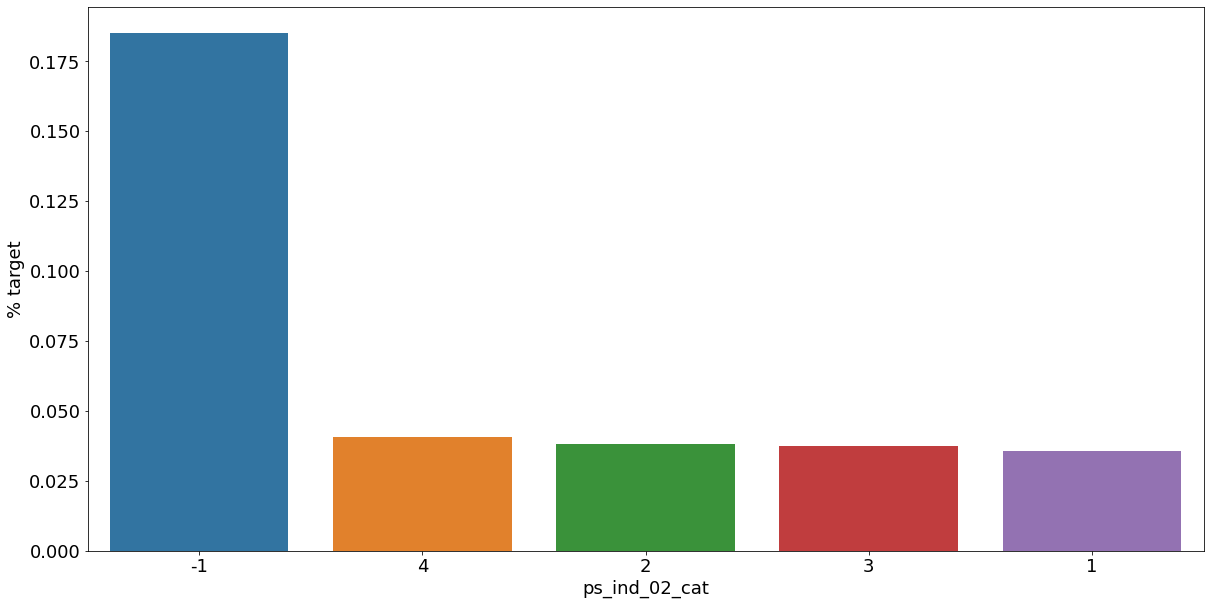

<Figure size 432x288 with 0 Axes>

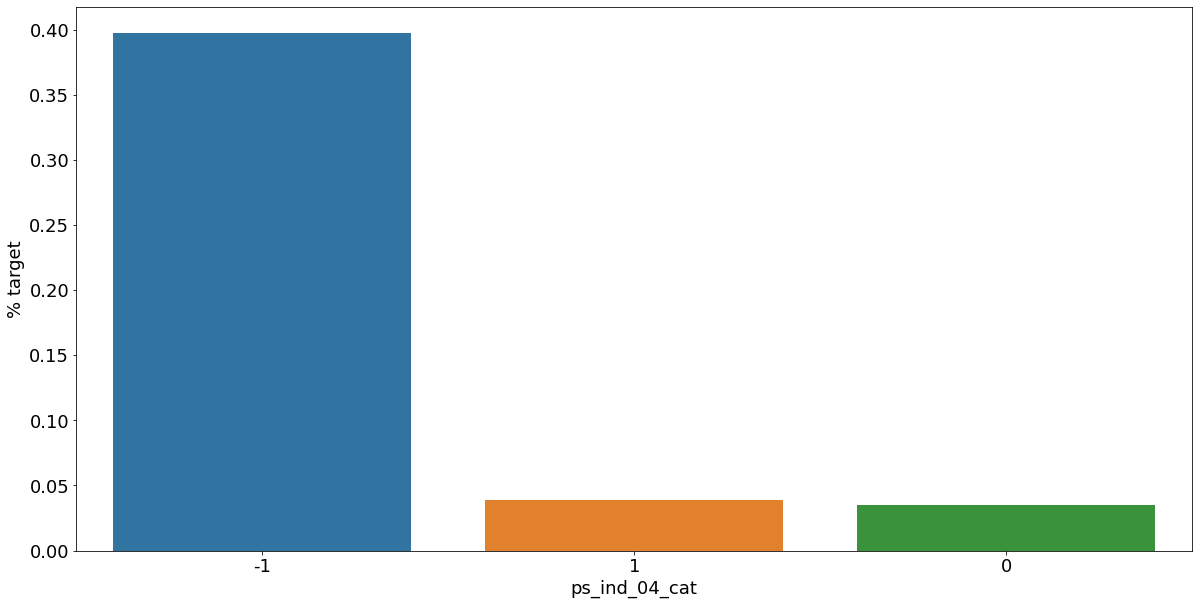

<Figure size 432x288 with 0 Axes>

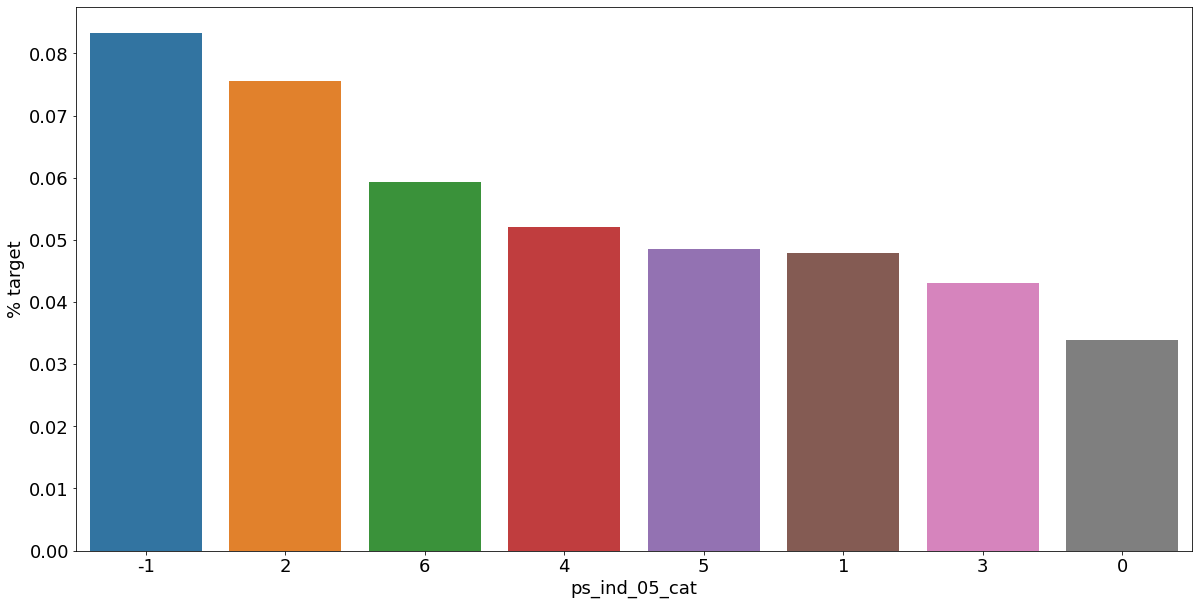

<Figure size 432x288 with 0 Axes>

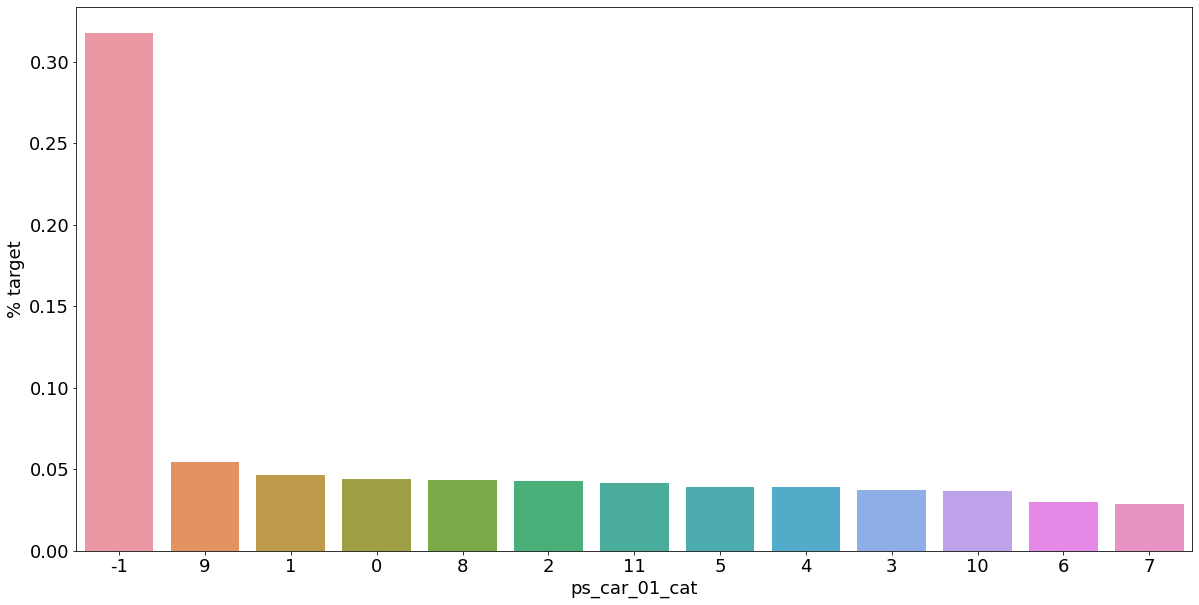

<Figure size 432x288 with 0 Axes>

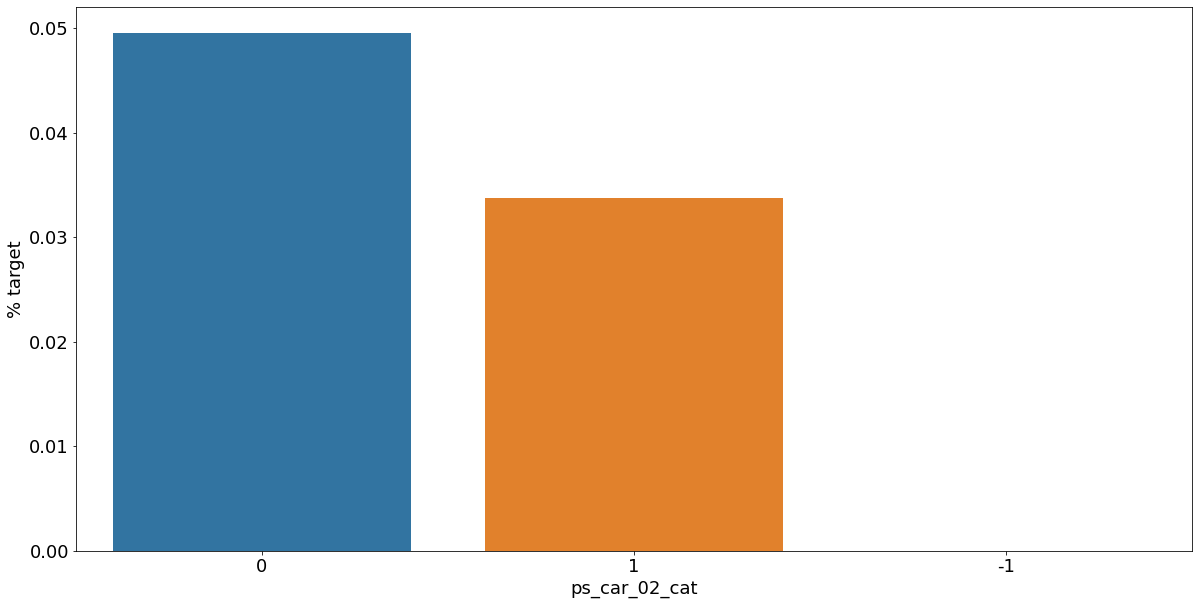

<Figure size 432x288 with 0 Axes>

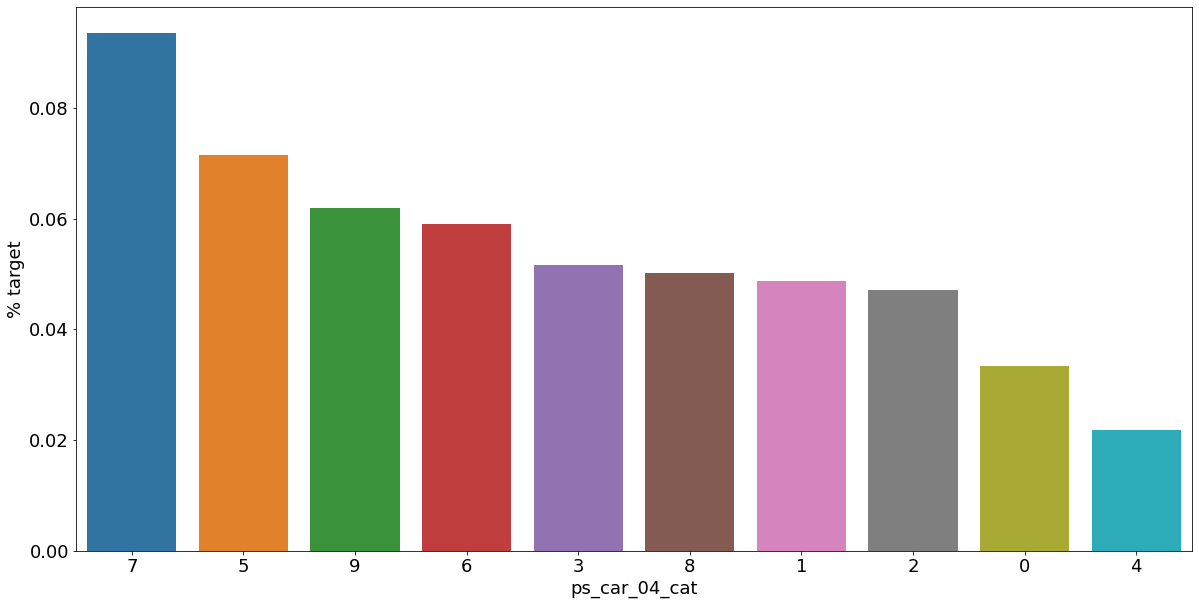

<Figure size 432x288 with 0 Axes>

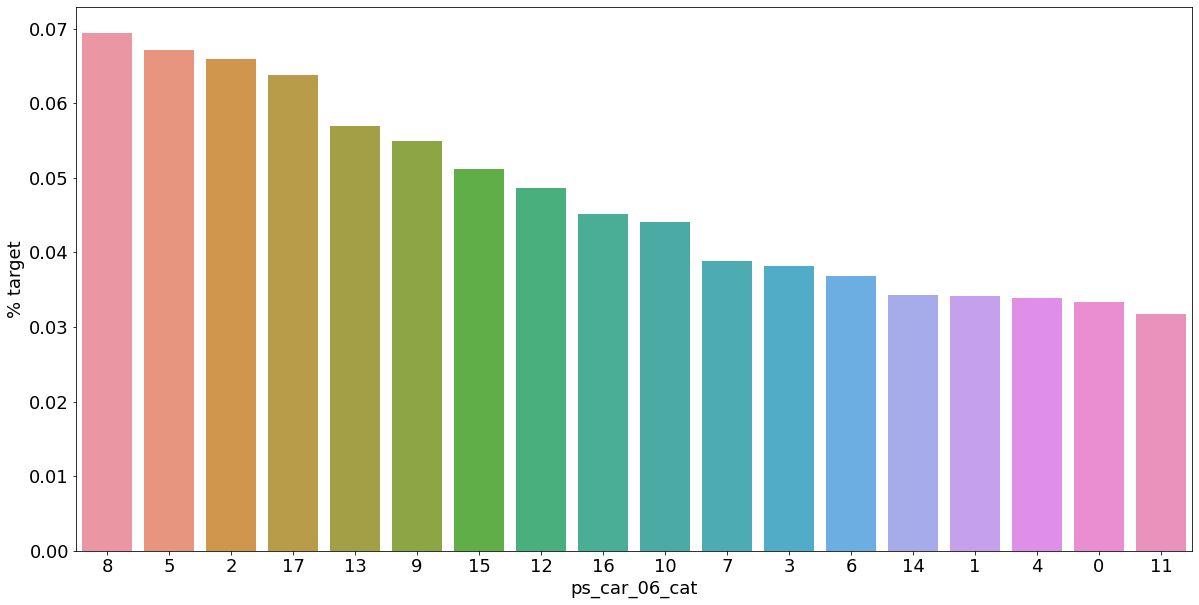

<Figure size 432x288 with 0 Axes>

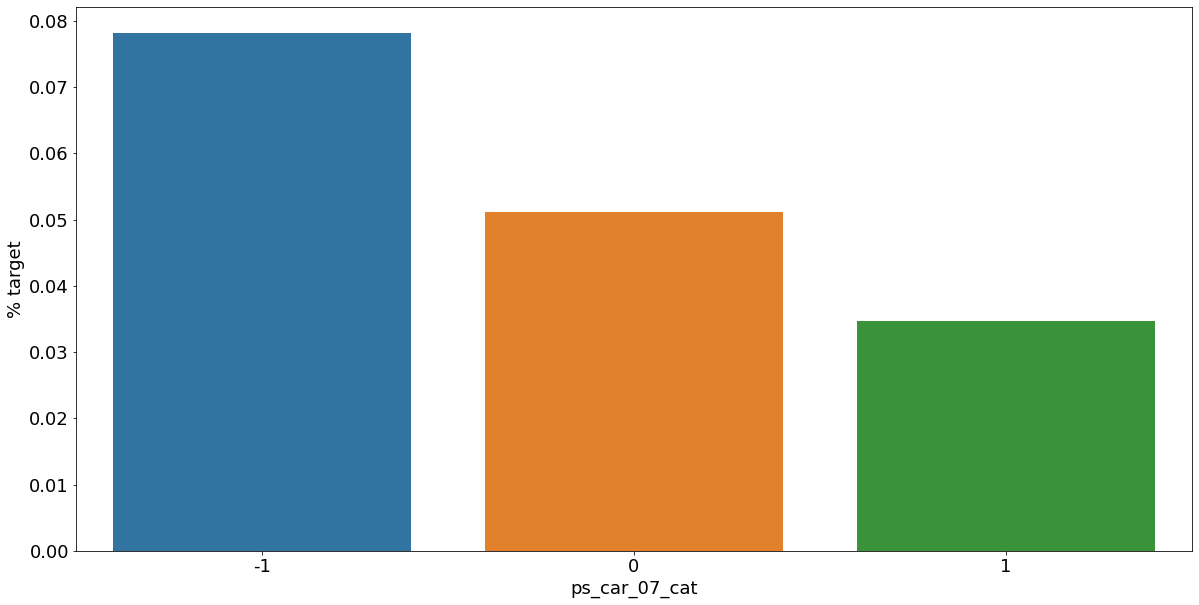

<Figure size 432x288 with 0 Axes>

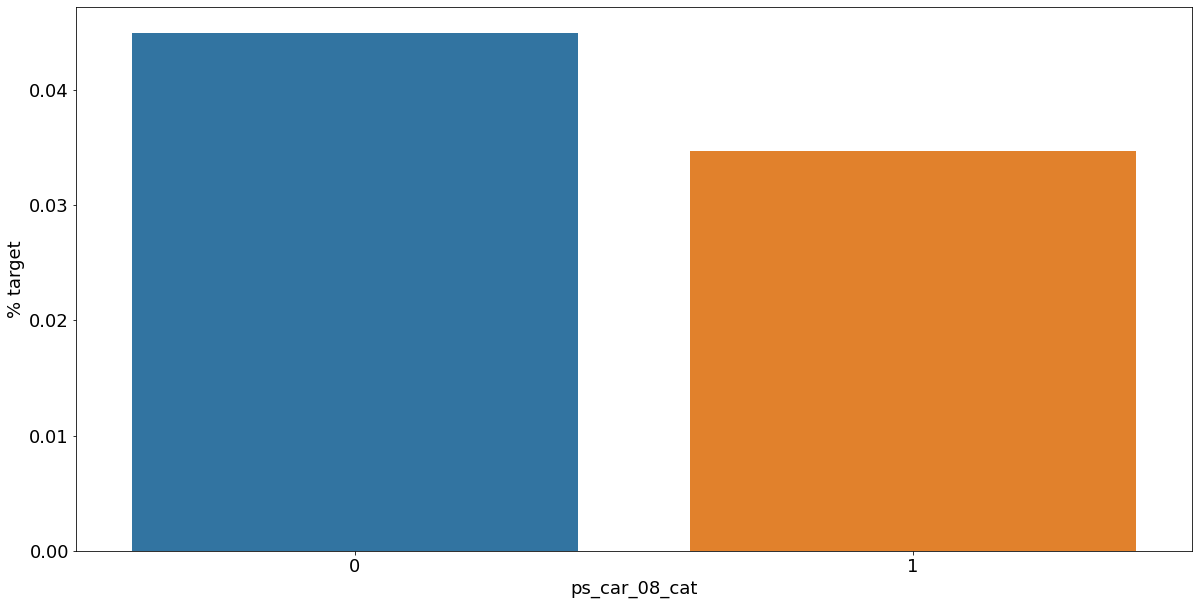

<Figure size 432x288 with 0 Axes>

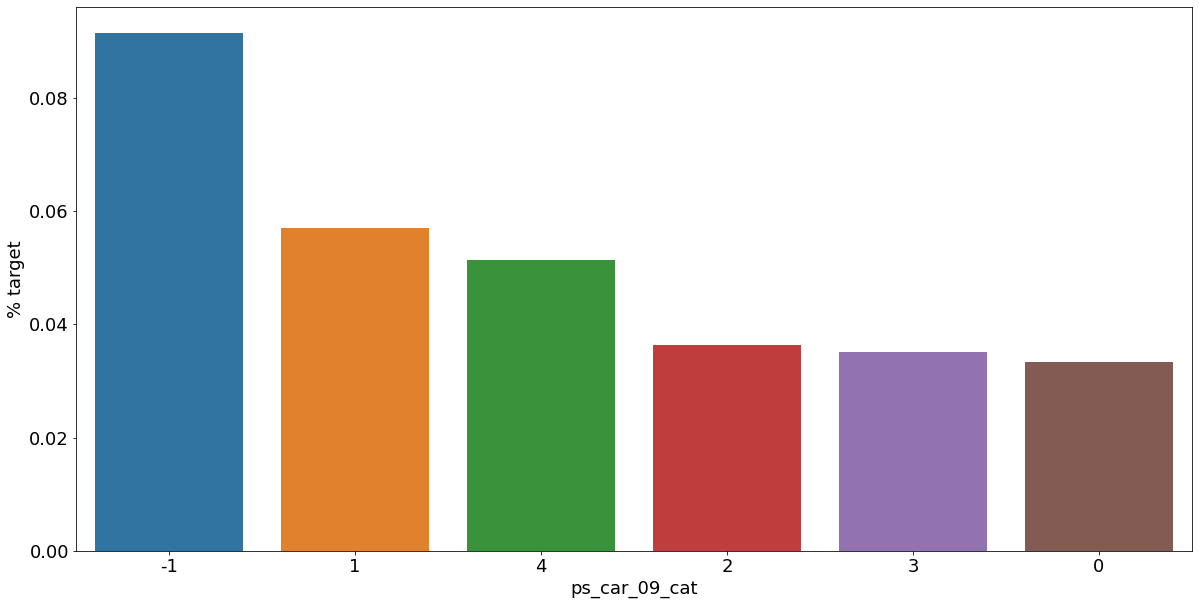

<Figure size 432x288 with 0 Axes>

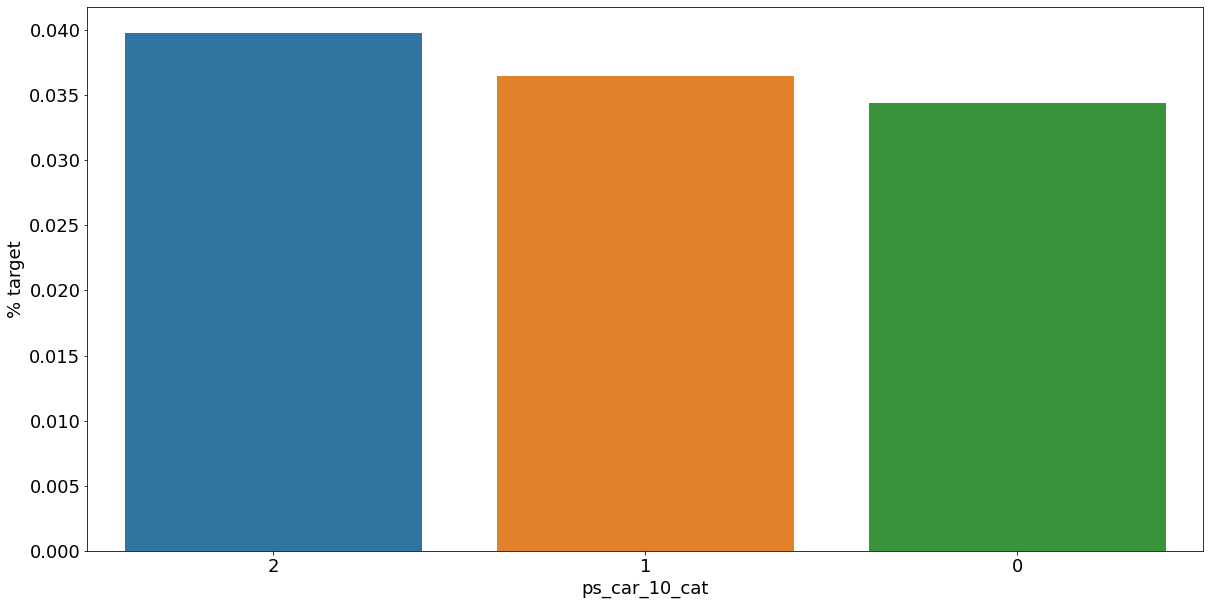

In [26]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # Calculate the percentage of target=1 per category value
    cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

Interval variables Checking the correlations between interval variables.

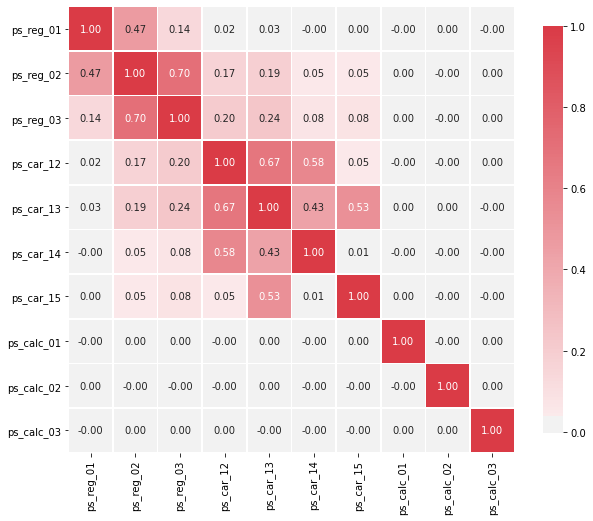

In [27]:
def corr_heatmap(v):
    correlations = train[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)


There are a strong correlations between the variables:
ps_reg_02 and ps_reg_03 (0.7) ps_car_12 and ps_car13 (0.67) ps_car_12 and ps_car14 (0.58) ps_car_13 and ps_car15 (0.67)

In [28]:
# Create correlation matrix
corr_matrix = train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.55
to_drop = [column for column in upper.columns if any(upper[column] > 0.55)]

In [29]:
print(corr_matrix.loc['ps_reg_02']['target'])   #keep
print(corr_matrix.loc['ps_reg_03']['target'])
print(corr_matrix.loc['ps_car_12']['target'])   #keep
print(corr_matrix.loc['ps_car_14']['target'])
print(corr_matrix.loc['ps_car_13']['target'])   #keep
print(corr_matrix.loc['ps_car_15']['target']) 

0.034800020810035914
0.0312575622008158
0.038800345270950956
0.011202750201249615
0.05389877948490931
0.0276672810272946


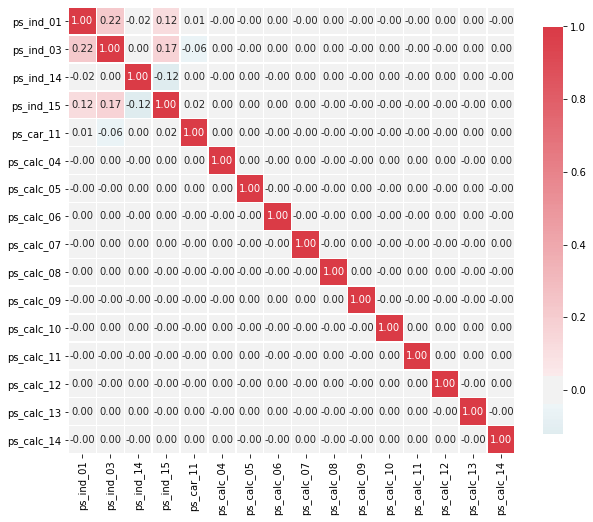

In [30]:
#Checking the correlations between ordinal variables
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

In [31]:
#Feature engineering - before adding hot encoding combining train and test set
train['tstatus'] = 1
test['tstatus'] = 0

combData = pd.concat([train,test])  #haven’t specified the axis, combining along rows

In [32]:
len(combData[combData['target'].isna()])

892816

In [33]:
#Feature engineering
#Creating dummy variables

v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in combined dataset'.format(combData.shape[1]))

combData = pd.get_dummies(combData, columns=v, drop_first=True)
print('After dummification we have {} variables in combined dataset'.format(combData.shape[1]))

Before dummification we have 58 variables in combined dataset
After dummification we have 110 variables in combined dataset


In [34]:
combData.head()

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,...,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_1,ps_car_06_cat_2,ps_car_06_cat_3,ps_car_06_cat_4,ps_car_06_cat_5,ps_car_06_cat_6,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,ps_car_06_cat_10,ps_car_06_cat_11,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_14,ps_car_06_cat_15,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_07_cat_0,ps_car_07_cat_1,ps_car_08_cat_1,ps_car_09_cat_0,ps_car_09_cat_1,ps_car_09_cat_2,ps_car_09_cat_3,ps_car_09_cat_4,ps_car_10_cat_1,ps_car_10_cat_2
0,7,0.0,2,5,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,9,0.0,1,7,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0
2,13,0.0,5,9,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,0.894047,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0
3,16,0.0,0,2,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0
4,17,0.0,0,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0


In [35]:
combData.shape

(1488028, 110)

In [36]:
train = combData[combData['tstatus']==1]
train.shape

test = combData[combData['tstatus']==0]
test.shape

train.drop('tstatus',axis=1,inplace=True)
test.drop('tstatus',axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [37]:
#Creating interaction variables
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
interactions.drop(v, axis=1, inplace=True)  # Remove the original columns
#Concat the interaction variables to the combData data
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 109 variables in train
After creating interactions we have 164 variables in train


In [38]:
#Feature selection
#Removing features with low or zero variance

selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

29 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_0', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


We would lose rather many variables if we would select based on variance. But because we do not have so many variables, we'll let the classifier chose. For data sets with many more variables this could reduce the processing time.

With SelectFromModel we can specify which prefit classifier to use and what the threshold is for the feature importances. With the get_support method we can then limit the number of variables in the train data.

In [ ]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']



In [ ]:
test['target']

In [40]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
#X_test = test.set_index('id')

In [ ]:
y_train.iloc[7]

In [ ]:
# Feature scaling - standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [41]:
#Splitting the insurance dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

ins1_train, ins1_test, ins2_train, ins2_test= train_test_split(X_train,y_train,test_size=0.2, random_state=0)
                                                                         

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(ins1_train)

# Apply transform to both the training set and the test set.
ins1_train = scaler.transform(ins1_train)
ins1_test = scaler.transform(ins1_test)

pca = PCA(n_components = 50)
# actually run the fit algorithm
eigenbasis = pca.fit(ins1_train)
# transform our data using the learned transform
ins_Trainpca = eigenbasis.transform(ins1_train)
ins_Testpca = eigenbasis.transform(ins1_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

classifierR = RandomForestClassifier()
classifierR.fit(ins_Trainpca, ins2_train)
#classifierR.score(ins_Testpca, ins2_test)

y_pred = classifierR.predict_proba(ins_Testpca)[:,1]
print(y_pred.shape)
print(ins2_test.shape)
print(y_pred)

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(ins2_test, y_pred)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(classifierR, ins_Trainpca, ins2_train, cv=5, scoring='roc_auc',n_jobs=-1)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

In [47]:
#trying XGBClassifier on dataset

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import time

# prepare cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# Parallel Thread XGBoost, Single Thread CV
start = time.time()
model = XGBClassifier(nthread=-1)
#model.fit(ins1_train, ins2_train)
results = cross_val_score(model, ins1_train, ins2_train, cv=kfold, scoring='roc_auc', n_jobs=1)
elapsed = time.time() - start
print("Results:", results)
print("Parallel Thread XGBoost, Multi Thread CV: %f" % (elapsed))





Parallel Thread XGBoost, Multi Thread CV: 2002.408646


In [ ]:
#We create a decorator to report the computation time

import time
from functools import wraps


def timeit(f):
    @wraps(f)
    def wrapper(*args, **kwds):
        start_time = time.time()
        result = f(*args, **kwds)
        elapsed_time = time.time() - start_time
        print('Elapsed computation time: {:.3f} secs'
              .format(elapsed_time))
        return (elapsed_time, result)
    return wrapper

In [ ]:
#Dependencies
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense,Dropout,Activation,BatchNormalization


def make_model(n_features):
    model = Sequential()
    model.add(Dense(200, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal', use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
from sklearn.metrics import roc_auc_score



def fit_predict_imbalanced_model(X_train, y_train, X_test, y_test):
    model = make_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=2, verbose=1, batch_size=1000)
    y_pred = model.predict_proba(X_test, batch_size=1000)
    return roc_auc_score(y_test, y_pred)

In [ ]:
from imblearn.keras import BalancedBatchGenerator

def fit_predict_balanced_model(X_train, y_train, X_test, y_test):
    model = make_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train,
                                                batch_size=1000,
                                                random_state=42)
    model.fit_generator(generator=training_generator, epochs=5, verbose=1)
    y_pred = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_pred)

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

cv_results_imbalanced = []
cv_time_imbalanced = []
cv_results_balanced = []
cv_time_balanced = []
    
for train_index, val_index in skf.split(X_trainpca, y_train): 
    print("Train:", train_index, "Validation:", val_index) 
    X_local_train, X_local_test = X_trainpca[train_index], X_trainpca[val_index] 
    y_local_train, y_local_test = y_train[train_index], y_train[val_index] 
    
    print("X_local_train:",X_local_train.shape)
    print("y_local_train:",y_local_train.shape)
    print("X_local_test:",X_local_test.shape)
    print("y_local_test:",y_local_test.shape)
    
    start_time = time.time()
    roc_auc = fit_predict_imbalanced_model(
        X_local_train, y_local_train, X_local_test, y_local_test)
    cv_time_imbalanced.append(time.time() - start_time)
    cv_results_imbalanced.append(roc_auc)

    start_time = time.time()
    roc_auc = fit_predict_balanced_model(
        X_local_train, y_local_train, X_local_test, y_local_test)
    cv_time_balanced.append(time.time() - start_time)
    cv_results_balanced.append(roc_auc)
    






In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X_train, y_train): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_test = X[train_index], X[val_index] 
    y_train, y_test = y[train_index], y[val_index]